In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import tqdm
import sys
import pdb

In [2]:
MU = .015
MTOL = sys.float_info.min
h = .02
Time = 30
D = 2

p0 = np.array([[0.],[np.sqrt(1.6/.4)]]).reshape(2,1)
q0 = np.array([[.4],[0.]]).reshape(2,1)

In [3]:
import pdb
def T(p):
    return np.squeeze(p.T.dot(p)/2)

def U(q):
    qnorm = np.linalg.norm(q)
    return np.squeeze(-(1/qnorm) - (MU/(3*qnorm**3)))

def H(p,q):
    return T(p) + U(q)

def gradU(q):
    qnorm = np.linalg.norm(q)
    return ((1/qnorm**3)+(MU/qnorm**5))*q

def gradT(p):
    return p

def Sigma(q):
    return np.dot(q.T,q)**(3/4.)

def G1(p,q):
    return -(3/2)*np.dot(p.T,q)/np.dot(q.T,q)

# Stormer-Verlet
def sv(du, p, q, h, time):
    steps = int(time//h)
    position = np.zeros((2,steps))
    energy = []
    H0 = H(p,q)
    for i in range(steps):
        p -= (h/2)*du(q)
        q += h*p
        p -= (h/2)*du(q)
        position[:,i] = np.squeeze(q)
        energy.append(np.squeeze(H(p,q)-H0))
    return position, energy

p = np.array([[0.],[np.sqrt(1.6/.4)]]).reshape(2,1)
q = np.array([[.4],[0.]]).reshape(2,1)
print(f'Initial Energy: {np.squeeze(H(p,q))}')
Q1, energy_sv = sv(gradU, p,q,h, Time)

def v_sv(G, p, q, eps, time):
    position = []
    energy = []
    stepsz = []
    ctrlerr = []
    H0 = H(p,q)
    totalStep = 0.
    s0 = Sigma(q)
    zhalf = (1/s0) + eps*G(p,q)/2
    z = np.copy(zhalf)
    while(totalStep < time):
        p += -eps*gradU(q)/(2*z)
        q += eps*gradT(p)/z
        p += -eps*gradU(q)/(2*z)
        
        totalStep += eps/z
        stepsz.append(eps/z)
        energy.append(np.squeeze(H(p,q)-H0))
        position.append(q.tolist())
        
        z += eps*G(p,q)
        ctrlerr.append(z*Sigma(q) - zhalf*s0)
        
    return position, energy, stepsz,ctrlerr

p0 = np.array([[0.],[np.sqrt(1.6/.4)]]).reshape(2,1)
q0 = np.array([[.4],[0.]]).reshape(2,1)
Q1vsv, energy_vsv, ssz_vsv, cerr_vsv = v_sv(G1, p0,q0,h, Time)
Q1_vsv  = np.array(Q1vsv).reshape((D,len(Q1vsv)))

Initial Energy: -0.578125


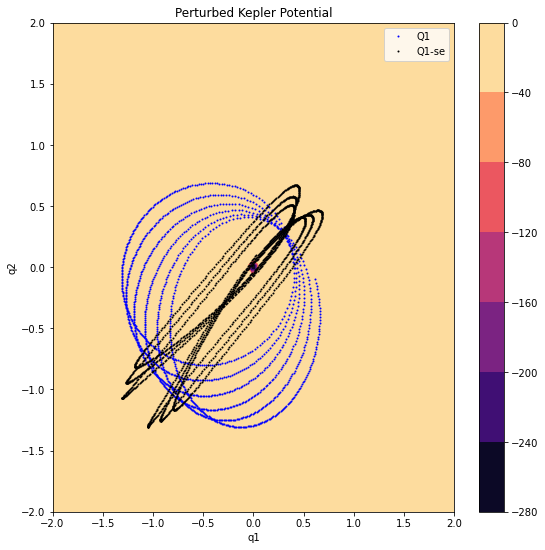

In [4]:
bnd = 2.
xlist = np.linspace(-bnd, bnd, 100)
ylist = np.linspace(-bnd, bnd, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = -(1/np.sqrt(X**2 + Y**2)) - (MU/(3*np.sqrt(X**2 + Y**2)**3))
fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z, cmap = 'magma')
ax.plot(Q1[0,:],Q1[1,:],'b.',linewidth=.001, markersize=2, label='Q1')
ax.plot(Q1_vsv[0,:],Q1_vsv[1,:],'k.',linewidth=.1, markersize=2, label='Q1-se')
ax.set_xlim(-bnd,bnd)
ax.set_ylim(-bnd,bnd)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Perturbed Kepler Potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()

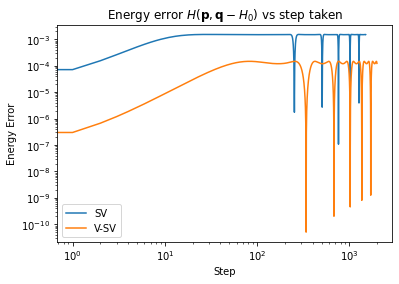

In [5]:
plt.loglog(energy_sv, label='SV')
plt.loglog(energy_vsv, label='V-SV')
plt.legend()
plt.title('Energy error $H(\mathbf{p},\mathbf{q} - H_{0})$ vs step taken')
plt.xlabel('Step')
plt.ylabel('Energy Error')
plt.show()

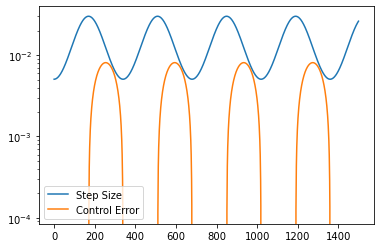

In [7]:
plt.semilogy(np.squeeze(ssz_vsv)[:int(30/h)], label='Step Size')
plt.semilogy(np.squeeze(cerr_vsv)[:int(30/h)], label= 'Control Error')
plt.legend()
plt.show()